In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(0)

In [3]:
# Import data
train = datasets.get_mnist('balanced')
test = datasets.get_mnist('balanced', train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 12
nu = 0.0001
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'act_bi_lipschitzian_ae'

In [4]:
# Initialize dimensions, models, parameters and optimizers
dims = [M, 835, 835, len(train.classes)]

model_kwargs = {
    'activation_params': {},
    'device': device
}

nets = {
    "BiReLU": models.dense.AEDense(dims, activation=modules.BiReLU, **model_kwargs),
    "BiELU": models.dense.AEDense(dims, activation=modules.BiELU, **model_kwargs),
    "BiCELU": models.dense.AEDense(dims, activation=modules.BiCELU, **model_kwargs),
}

# Initialize with same parameters
for k, model in nets.items():
    loss_trace[k] = {}
    j = list(nets.keys())[0]
    if k != j:
        nets[k].net_fwd.V.weight.data = nets[j].net_fwd.V.weight.data.clone()
        nets[k].net_fwd.W1.weight.data = nets[j].net_fwd.W1.weight.data.clone()
        nets[k].net_fwd.U.weight.data = nets[j].net_fwd.U.weight.data.clone()
        nets[k].net_bck.V.weight.data = nets[j].net_bck.V.weight.data.clone()
        nets[k].net_bck.W1.weight.data = nets[j].net_bck.W1.weight.data.clone()
        nets[k].net_bck.U.weight.data = nets[j].net_bck.U.weight.data.clone()
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)
    

In [5]:
# Define objective function

def objective_function(x, xh, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    losses['lx'] = F.mse_loss(xh, x, reduction=reduction)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [6]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:8}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params BiReLU  :  2787324
No. params BiELU   :  2787324
No. params BiCELU  :  2787324


In [7]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.tensor(train.data[sample_indices_small]).float() / 255
xs = xims.flatten(-2, -1).to(device)
xt = torch.tensor(test.data).float().flatten(-2, -1).to(device) / 255

index_matrix = torch.eye(len(train.classes)).to(device)
yt = index_matrix[test.targets]

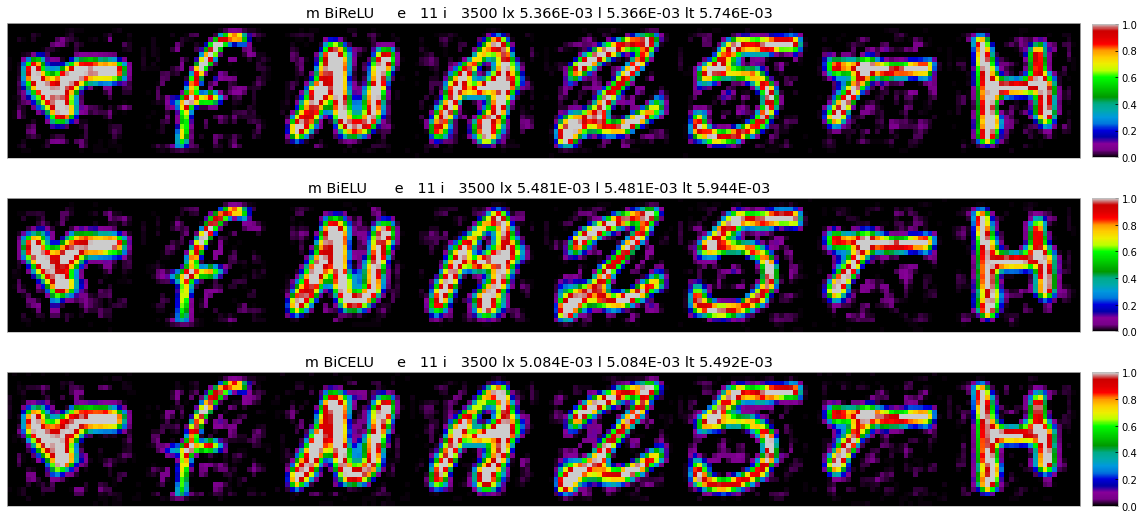

In [8]:
# Training loop

for e in range(epochs):
    i = 0
    for x, _y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            y = nets[cur](x)
            xh = nets[cur].T(y)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh)

            loss.backward()
            opts[cur].step()
            
            # Validation
            with torch.no_grad():
                yt = nets[cur](xt)
                xth = nets[cur].T(yt)
                ldicts[cur]['lt'] = F.mse_loss(xth, xt, reduction='mean')

            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 50 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    ys = nets[cur](xs)
                    xhs[cur] = nets[cur].T(ys)
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name)
            
        i += 1

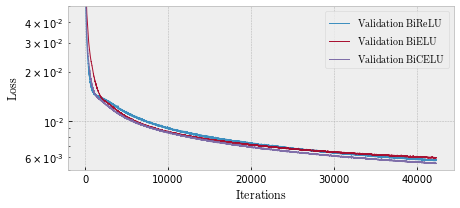

In [9]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    plt.plot(np_loss_trace[k]["lt"], linewidth=1, label=f"$\mathrm{{Validation\,\,{k}}}$", alpha=0.95)

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
plt.ylim(0.005, 0.05)
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

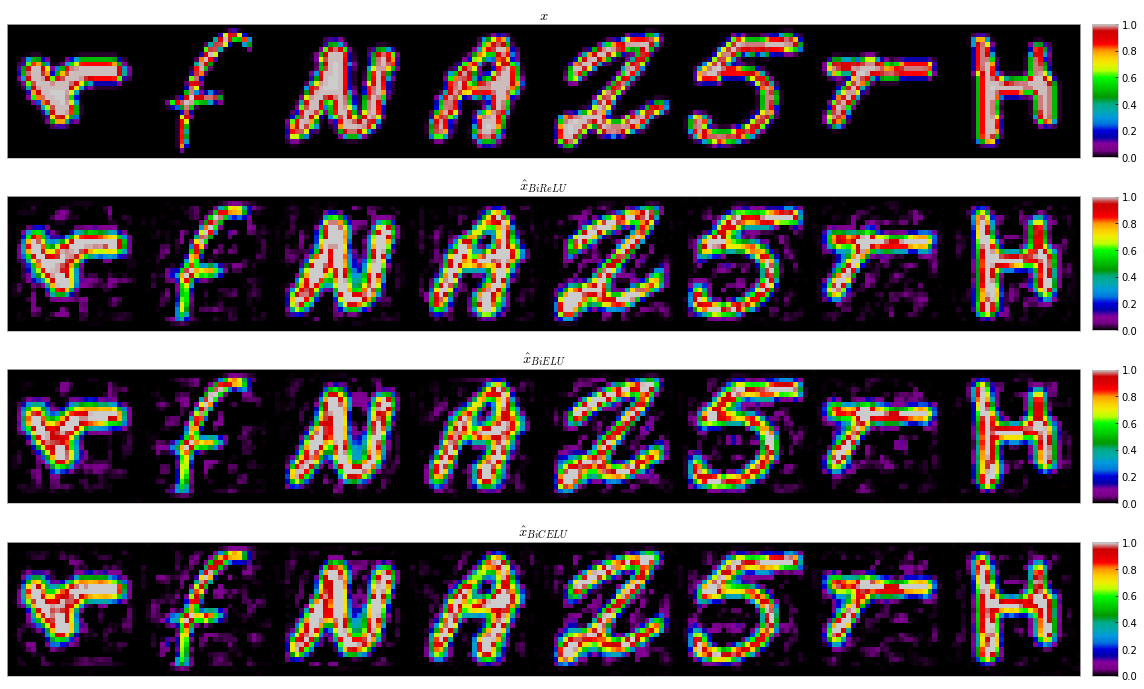

In [10]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to(device)
    
# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = nets[k].T(nets[k](xs, sample=False))
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
    
utils.reporting.plot_results(xhs, '', fname=experiment_name)

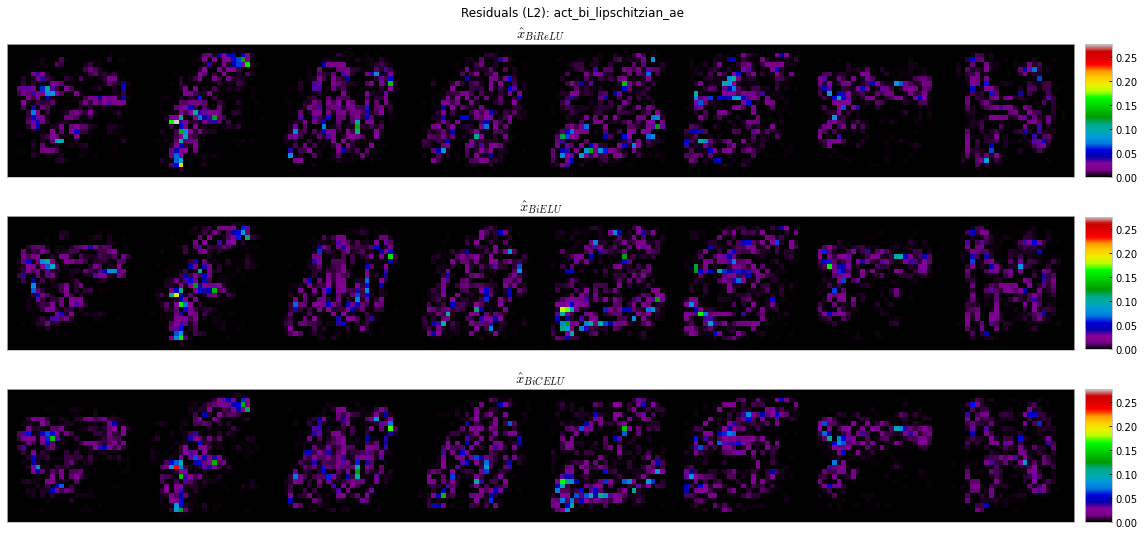

In [11]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = nets[k].T(nets[k](xs))
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
        xhs[k] = (xhs[k] - xims)**2
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [12]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [13]:
# Calculate relative error on test data
test_tensor = torch.tensor(test.data.astype(float) / 255).flatten(-2, -1).float()

print(f"Relative Error:")
for k, model in nets.items():
    xth = model.T(model(test_tensor))
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(xth, test_tensor, reduction='mean'):4E} " +
        f"MSE {F.mse_loss(xth, test_tensor, reduction='mean'):4E} "
    )

Relative Error:
BiReLU: RE 2.058668E-01 MSE 5.780715E-03 
BiELU : RE 2.101329E-01 MSE 5.943956E-03 
BiCELU: RE 2.012623E-01 MSE 5.507976E-03 


In [14]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    XH = model.T(model(test_tensor))
    psnr = utils.metrics.psnr(test_tensor, XH)
    ssim = utils.metrics.ssim(
        test_tensor.unflatten(-1, (28, 28))[None,...], 
        XH.unflatten(-1, (28, 28))[None,...]
    )
    print(
        f"{k:6}: " + 
        f"PSNR {psnr:4E} " +
        f"SSIM {ssim:4E} "
    )

# Clear memory
del XH

Image Reconstruction Metrics:
BiReLU: PSNR 2.238018E+01 SSIM 8.370626E-01 
BiELU : PSNR 2.225924E+01 SSIM 8.376225E-01 
BiCELU: PSNR 2.259008E+01 SSIM 8.474844E-01 


In [15]:
# Compute Estimated Generalized Inverses
Ids = {}
for k, model in nets.items():
    with torch.no_grad():
        dct = model.get_weight_dict()
        Ids[k] = dct['V.T'] @ dct['U.T'] @ dct['U'] @ dct['V']

# Note: Moore-Penrose Pseudoinverse is calculated using test data
#       which has fewer (18800) observations than training (112800)
Ids['PIn'] = torch.pinverse(test_tensor) @ test_tensor

In [16]:
# Relative error to Identity
print("Relative Error w.r.t. Identity (Frobenius Norm):")
for k, I in Ids.items():
    print(f"{k:8}: {utils.metrics.relative_error_matrix(torch.eye(M), I, 'fro')}")

Relative Error w.r.t. Identity (Frobenius Norm):
BiReLU  : 1.0006906986236572
BiELU   : 1.003552794456482
BiCELU  : 1.0014456510543823
PIn     : 0.5413821935653687


In [17]:
print("Relative Error w.r.t. symmetry of Moore-Penrose properties (Frobenius Norm):")
for k, I in Ids.items():
    print(f"{k:8}: {utils.metrics.relative_error_matrix(test_tensor, test_tensor @ I, 'fro'):.6f}")

Relative Error w.r.t. symmetry of Moore-Penrose properties (Frobenius Norm):
BiReLU  : 0.997016
BiELU   : 1.081419
BiCELU  : 1.030103
PIn     : 0.000071


In [18]:
# Calculate condition numbers
print("Condition Numbers:")
for i, (k, I) in enumerate(Ids.items()):
    kappa = torch.linalg.cond(I)
    print(f'{k:8} {kappa.item():5E}')

Condition Numbers:
BiReLU   1.300511E+09
BiELU    8.951832E+08
BiCELU   1.727359E+09
PIn      2.398625E+08


In [19]:
# Calculate approximate Lipshitz constants / spectral norms
print("Lipschitz Constants:")
for k, model in nets.items():
    dct = model.get_weight_dict()
    lipschitz_constants = torch.tensor([
        utils.metrics.stochastic_spectral_norm(w, 15) 
        for w in dct.values()
    ])
    lipschitz_product = torch.prod(lipschitz_constants)
    print(f'{k:8} {lipschitz_product.item():5E}')

Lipschitz Constants:
BiReLU   3.117259E+01
BiELU    1.728215E+02
BiCELU   1.515872E+02


In [20]:
# Calculate actual Lipshitz constants / spectral norms
# Note: In encoder/decoder models, the Lipschitz constants of the activation cancel out
print("Lipschitz Constants:")
for k, model in nets.items():
    dct = model.get_weight_dict()
    lipschitz_constants = torch.tensor([
        torch.svd(w)[1][0]
        for w in dct.values()
    ])
    lipschitz_product = torch.prod(lipschitz_constants)
    print(f'{k:8} {lipschitz_product.item():5E}')

Lipschitz Constants:
BiReLU   3.380589E+01
BiELU    1.892353E+02
BiCELU   1.633395E+02


In [21]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Calculate estimated Jacobian from test data
# NOTE: This process can take upwards of 10 minutes
no_cond = 1000
_x = test_tensor.clone()[:no_cond].to(device)
_x.requires_grad = True
Js = {}
for k, model in nets.items():
    Js[k] = torch.zeros(no_cond, M, M)
    for i in tqdm(range(no_cond)):
        model.zero_grad()
        Js[k][i] = torch.autograd.functional.jacobian(
            lambda x: model.T(model(x)),
            _x[i]
    ).cpu()

# Move models to CPU
for k in nets:
    nets[k] = nets[k].to('cpu')

# Move samples to CPU
_x = _x.to('cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
print("Jacobian Relative Condition Numbers (Frobenius Norm):")
for k, J in Js.items():
    _xh = nets[k].T(nets[k](_x))
    rel = torch.mean(torch.linalg.norm(_xh, dim=1) / torch.linalg.norm(_x, dim=1))
    Jnorm = torch.mean(torch.linalg.norm(J, dim=(1,2)))
    relnorm = torch.mean(
        torch.linalg.norm(J, dim=(1,2)) / (torch.linalg.norm(_xh, dim=1) / torch.linalg.norm(_x, dim=1))
    )
    print(f"{k:8} den: {rel:.6E} abs_cond: {Jnorm:.6E} rel_cond: {relnorm:.6E}") 

Jacobian Relative Condition Numbers (Frobenius Norm):
BiReLU   den: 9.814280E-01 abs_cond: 1.137589E+01 rel_cond: 1.160104E+01
BiELU    den: 9.741264E-01 abs_cond: 1.199625E+01 rel_cond: 1.232436E+01
BiCELU   den: 9.774608E-01 abs_cond: 1.156990E+01 rel_cond: 1.184519E+01


In [23]:
print("Jacobian Relative Condition Numbers (L2 Norm):")
for k, J in Js.items():
    _xh = nets[k].T(nets[k](_x))
    relnorm = torch.mean(
        torch.linalg.norm(J, dim=(1,2), ord=2) / (torch.linalg.norm(_xh, dim=1, ord=2) / torch.linalg.norm(_x, dim=1, ord=2))
    )
    print(f"{k:3} rel_cond: {relnorm:.6E}") 

Jacobian Relative Condition Numbers (L2 Norm):
BiReLU rel_cond: 3.467319E+00
BiELU rel_cond: 4.500218E+00
BiCELU rel_cond: 3.886375E+00


In [24]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [25]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

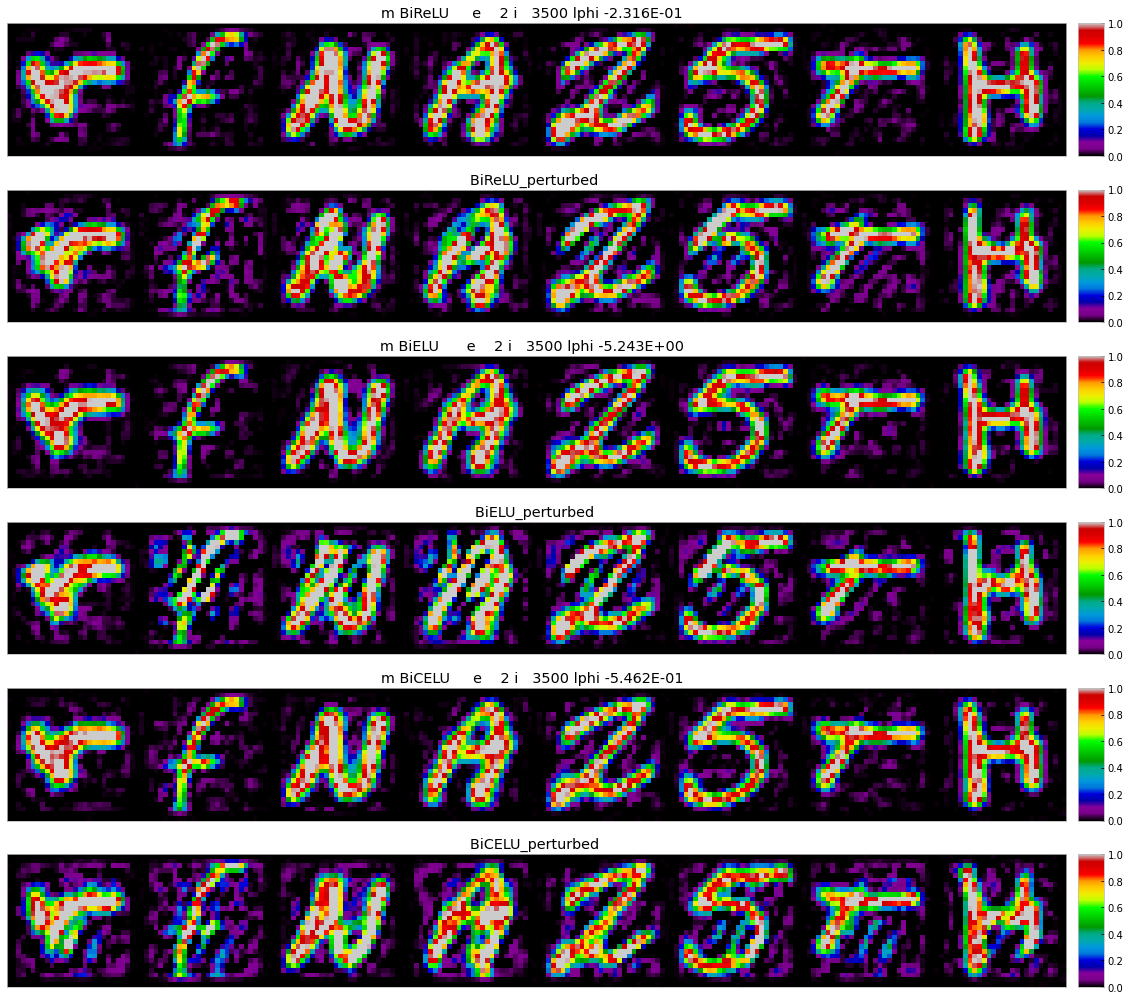

In [26]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur](x)
            xe = nets[cur](x + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(nets[cur](xs))
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
                    xhs[per] = nets[cur].T(nets[cur](xs + r))
                    xhs[per] = xhs[per].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

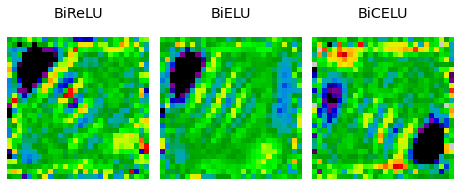

In [27]:
fig, ax = plt.subplots(1, 3)
for i, (k, r) in enumerate(rs.items()):
    ax[i].matshow(r.to('cpu').unflatten(-1, train.size).detach(), vmin=-1, vmax=1)
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].set_title(k)

plt.savefig(f'../figures/misc/{experiment_name}_perturbationvecs.pdf')

In [28]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Error:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(test_tensor + r))
    print(f"{k:6}: {utils.metrics.relative_error(test_tensor + rs[k].cpu(), XE, reduction='mean')}")


print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(test_tensor + r))
    XH = model.T(model(test_tensor))

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor, test_tensor + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH, XE, test_tensor, r, reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Error:
BiReLU: 0.8285045027732849
BiELU : 0.8309298157691956
BiCELU: 0.8336004614830017
Relative Cond:
BiReLU: 0.268384 0.098739 10.942023
BiELU : 0.481147 0.098739 19.616358
BiCELU: 0.309057 0.098739 12.600259


In [29]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [30]:
# Save weights

export_weights = {}
for k in nets:
    export_weights[k] = nets[k].get_weight_dict()
    for l in export_weights[k]:
        export_weights[k][l] = export_weights[k][l].detach().numpy().tolist()

with open(f'{serialized_path}weights.pickle', 'wb') as outfile:
    pickle.dump(export_weights, outfile)

In [31]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [47]:
# Estimate relative condition number in opposite direction (y)

# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(len(train.classes)).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

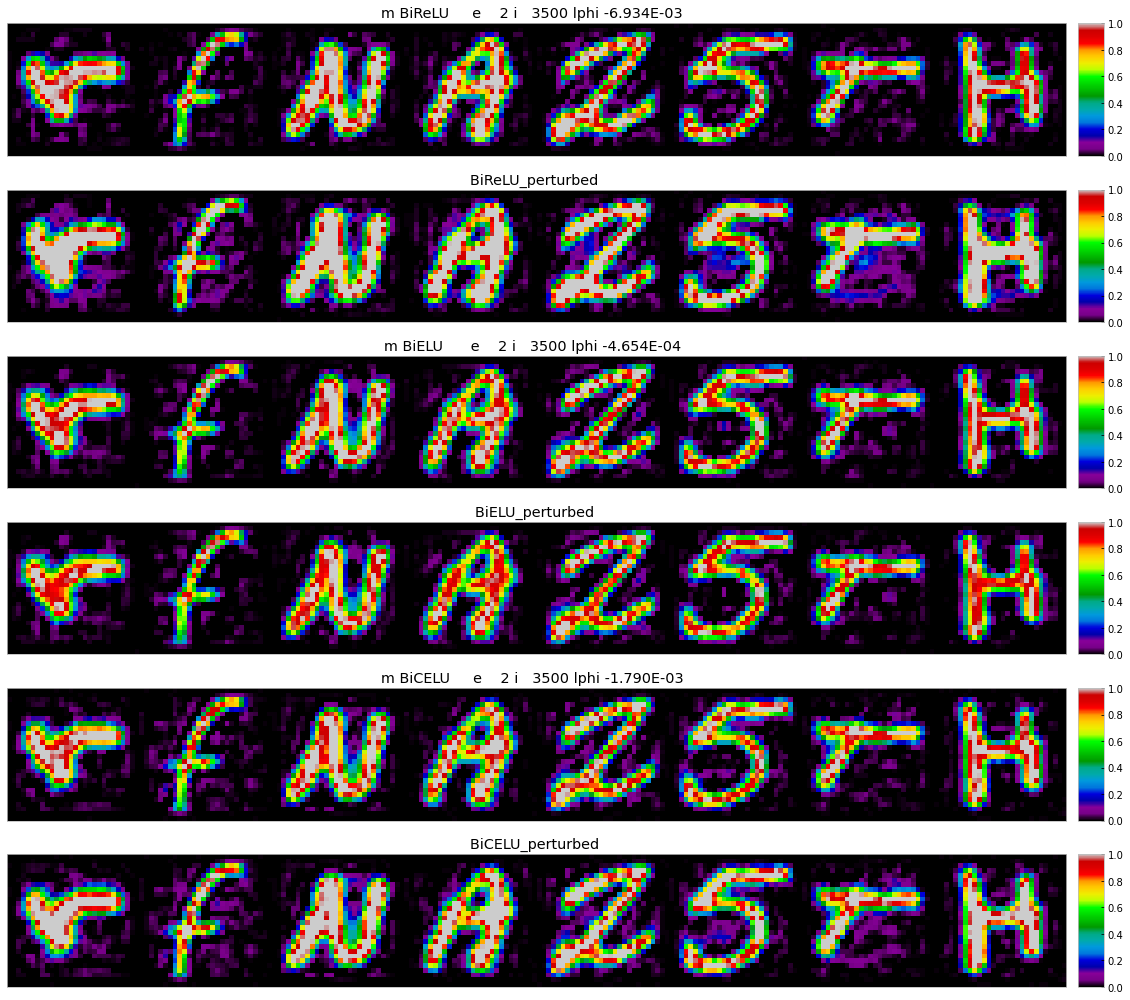

In [48]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur].T(nets[cur](x))
            xe = nets[cur].T(nets[cur](x) + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(nets[cur](xs))
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
                    xhs[per] = nets[cur].T(nets[cur](xs) + r)
                    xhs[per] = xhs[per].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

In [51]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(test_tensor) + r)
    XH = model.T(model(test_tensor))

    cond_no = utils.metrics.relative_cond_no(XH, XE, test_tensor, r, reduction='mean')
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
BiReLU: 9.493530
BiELU : 2.421623
BiCELU: 4.777240
